In [ ]:
import os
import time
import shutil
import random

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 128
WIDTH = 224
HEIGHT = 224
LEARNING_RATE = 0.0001
CLASSES = 29
SEED = random.randint(1, 1000)

# Setting path

In [ ]:
TRAIN_DIR = 'vietnamese-foods/Images/train'
VAL_DIR = 'vietnamese-foods/Images/validate'
TEST_DIR = 'vietnamese-foods/Images/test'

In [ ]:
fine_tune_log = os.path.join('.', 'fine_tune.log')
final_model = os.path.join('.', 'final_model.h5')

# Preparing data

In [ ]:
datagen = ImageDataGenerator(
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9, 1.1],
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = SEED,
)

val_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = SEED,
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = SEED,
)

Found 17121 images belonging to 29 classes.
Found 2449 images belonging to 29 classes.
Found 4907 images belonging to 29 classes.


# Training model

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu', kernel_initializer=glorot_uniform(SEED), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(CLASSES, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in model.layers: layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint(
    final_model,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 20,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_lr = 0.0000001,
    min_delta =.0001,
    patience = 5,
    factor = np.sqrt(0.1),
    cooldown = 0,
    verbose = 1
)

In [ ]:
params = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // BATCH_SIZE, 
    validation_data = val_generator, 
    validation_steps = val_generator.n // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [checkpoint, early_stopping, reduce_lr, CSVLogger(fine_tune_log)],
    verbose = 1
)

Epoch 1/15
133/133 [==============================] - 555s 4s/step - loss: 2.5016 - accuracy: 0.3163 - val_loss: 1.5354 - val_accuracy: 0.6365

Epoch 00001: val_accuracy improved from -inf to 0.63651, saving model to /content/drive/MyDrive/DeepLearningFinal/base_model_.h5
Epoch 2/15
133/133 [==============================] - 539s 4s/step - loss: 0.8087 - accuracy: 0.7630 - val_loss: 0.8288 - val_accuracy: 0.7673

Epoch 00002: val_accuracy improved from 0.63651 to 0.76727, saving model to /content/drive/MyDrive/DeepLearningFinal/base_model_.h5
Epoch 3/15
133/133 [==============================] - 554s 4s/step - loss: 0.5131 - accuracy: 0.8556 - val_loss: 0.6891 - val_accuracy: 0.7977

Epoch 00003: val_accuracy improved from 0.76727 to 0.79770, saving model to /content/drive/MyDrive/DeepLearningFinal/base_model_.h5
Epoch 4/15
133/133 [==============================] - 567s 4s/step - loss: 0.3563 - accuracy: 0.9020 - val_loss: 0.6266 - val_accuracy: 0.8269

Epoch 00004: val_accuracy impro

# Evaluation

In [ ]:
acc = params.history['accuracy']
val_acc = params.history['val_accuracy']

loss = params.history['loss']
val_loss = params.history['val_loss']

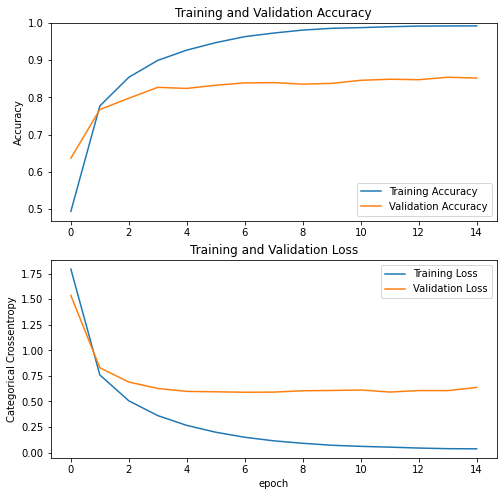

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Crossentropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.savefig('evaluation.jpg')
plt.show()

In [ ]:
model = load_model(final_model)
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

39/39 [==============================] - 129s 3s/step - loss: 0.6332 - accuracy: 0.8417
Test accuracy: 0.8416547775268555


In [ ]:
y_test = test_generator.classes
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       129
           1       0.78      0.76      0.77       144
           2       0.67      0.59      0.63       193
           3       0.93      0.83      0.88       149
           4       0.87      0.82      0.84       102
           5       0.88      0.85      0.86       228
           6       0.94      0.91      0.93       129
           7       0.88      0.88      0.88       167
           8       0.91      0.96      0.93       268
           9       0.85      0.94      0.89        89
          10       0.85      0.85      0.85       138
          11       0.87      0.89      0.88       159
          12       0.89      0.89      0.89       235
          13       0.70      0.85      0.77       306
          14       0.84      0.76      0.80       155
          15       0.80      0.76      0.78       231
          16       0.84      0.87      0.85       150
          17       0.96    